In [5]:
# Importations des bibliothèques nécessaires
import pandas as pd
import numpy as np

In [6]:
#importion du jeu de données
df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'text'])
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
# Encodage des labels : ham = 0, spam = 1
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [8]:
df

,label,text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will ü b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [9]:
# Téléchargement des ressources NLTK nécessaires
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michael/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/michael/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [11]:
# Fonction de nettoyage du texte
def clean_text(text):
    # 1. Mise en minuscule
    text = text.lower()
    # 2. Suppression ponctuation et caractères spéciaux (garde lettres et chiffres)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 3. Tokenisation (séparation des mots)
    words = text.split()
    # 4. Suppression stopwords et Stemming
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]
    # Reconstitution de la phrase
    return " ".join(cleaned_words)

In [12]:
# nettoyage des messages
import re
df['text_cleaned'] = df['text'].apply(clean_text)

In [13]:
# EXPORT DU FICHIER NETTOYÉ 
df.to_csv('sms_cleaned.csv', index=False)
print("Fichier nettoyé exporté : 'sms_cleaned.csv'")

Fichier nettoyé exporté : 'sms_cleaned.csv'


In [14]:
X = df['text_cleaned']
y = df['label_num']

In [15]:
# Division des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Vectorisation du texte avec TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Créer le vectoriseur sur l'ensemble d'entraînement
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()

# Garder seulement les HAM (label 0) pour entraîner l'autoencoder
X_train_ham = X_train_vectorized[y_train.values == 0]


print(f"Forme des données vectorisées - Entraînement: {X_train_vectorized.shape}")
print(f"Forme des données vectorisées - Test: {X_test_vectorized.shape}")

Forme des données vectorisées - Entraînement: (4457, 1000)
Forme des données vectorisées - Test: (1115, 1000)


In [17]:
# Autoencoder Avec Keras
from keras.models import Model
from keras.layers import Input, Dense

input_dim = X_train_vectorized.shape[1]
encoding_dim = 32  # Dimension de l'espace latent

# Architecture de l'Autoencoder
input_layer = Input(shape=(input_dim,))
# Couche d'encodage
encoded = Dense(encoding_dim, activation='relu')(input_layer)
# Couche de décodage
decoded = Dense(input_dim, activation='sigmoid')(encoded)

2025-12-11 19:50:08.398793: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Création et compilation du modèle
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entraînement du modèle
history = autoencoder.fit(
    X_train_ham, X_train_ham,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)


print("Modèle Autoencoder entraîné avec succès!")

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6451 - val_loss: 0.3078
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2132 - val_loss: 0.0647
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0539 - val_loss: 0.0318
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0296 - val_loss: 0.0232
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - val_loss: 0.0198
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - val_loss: 0.0182
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0174
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 - val_loss: 0.0168
Epoch 9/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 10/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0164 - val_loss: 0.0163
Modèle Autoencoder entraîné avec succès!


In [19]:
# EXTRACTION DE L'ENCODEUR (Réduction de dimensions)
encoder = Model(input_layer, encoded)

# Transformation des données avec l'encodeur (1000 -> 32 dimensions)
X_train_reduced = encoder.predict(X_train_vectorized)
X_test_reduced = encoder.predict(X_test_vectorized)

print(f"Forme originale: {X_train_vectorized.shape}")
print(f"Forme réduite: {X_train_reduced.shape}")
print(f"Réduction: {X_train_vectorized.shape[1]} -> {X_train_reduced.shape[1]} dimensions")

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Forme originale: (4457, 1000)
Forme réduite: (4457, 32)
Réduction: 1000 -> 32 dimensions


In [20]:
# CLASSIFICATION AVEC SVM SUR LES DONNÉES RÉDUITES
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\n" + "=" * 60)
print("ENTRAÎNEMENT DU SVM SUR LES DONNÉES COMPRESSÉES")
print("=" * 60)

# Entraînement du SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_reduced, y_train)

# Prédictions
y_pred = svm.predict(X_test_reduced)

# Résultats
print("\n--- RÉSULTATS SVM SUR DONNÉES RÉDUITES ---\n")
print("Matrice de confusion:")
cm_svm = confusion_matrix(y_test, y_pred)
print(cm_svm)

print("\nRapport de classification:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy globale: {accuracy:.4f} ({accuracy*100:.2f}%)")


ENTRAÎNEMENT DU SVM SUR LES DONNÉES COMPRESSÉES

--- RÉSULTATS SVM SUR DONNÉES RÉDUITES ---

Matrice de confusion:
[[966   0]
 [149   0]]

Rapport de classification:
              precision    recall  f1-score   support

         Ham       0.87      1.00      0.93       966
        Spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115


Accuracy globale: 0.8664 (86.64%)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


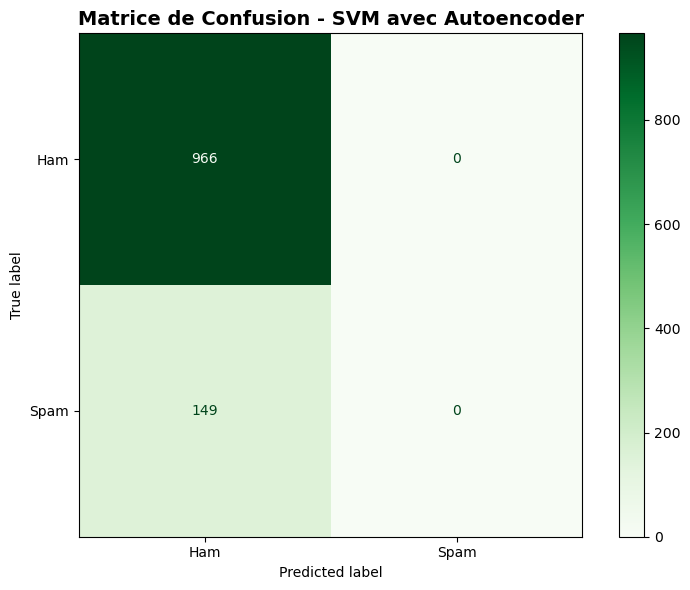

✅ Classification SVM terminée avec succès!


In [21]:
# Visualisation de la matrice de confusion SVM
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Ham', 'Spam'])
disp.plot(ax=ax, cmap='Greens', values_format='d')
ax.set_title('Matrice de Confusion - SVM avec Autoencoder', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Classification SVM terminée avec succès!")

In [22]:
# Reconstructions
X_train_ham_pred = autoencoder.predict(X_train_ham)
X_test_pred = autoencoder.predict(X_test_vectorized)

# Erreurs de reconstruction
train_mae = np.mean(np.abs(X_train_ham_pred - X_train_ham), axis=1)
test_mae  = np.mean(np.abs(X_test_pred - X_test_vectorized), axis=1)

# Seuil basé uniquement sur les HAM
threshold = np.percentile(train_mae, 95)

print(f"Erreur MAE moyenne - Train (HAM only): {train_mae.mean():.4f}")
print(f"Erreur MAE moyenne - Test (mix): {test_mae.mean():.4f}")
print(f"Seuil utilisé (95e percentile sur HAM): {threshold:.4f}")


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Erreur MAE moyenne - Train (HAM only): 0.0058
Erreur MAE moyenne - Test (mix): 0.0062
Seuil utilisé (95e percentile sur HAM): 0.0115


In [23]:

# Prédictions : 1 = anomalie (spam), 0 = normal (ham)
y_pred_test = (test_mae > threshold).astype(int)

# Évaluation des performances
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("=" * 50)
print("RÉSULTATS DE LA DÉTECTION D'ANOMALIES")
print("=" * 50)
print(f"\nSeuil utilisé: {threshold:.4f}\n")
print(classification_report(y_test, y_pred_test, target_names=['Ham', 'Spam']))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_test)
print("\nMatrice de confusion:")
print(cm)

# ROC AUC
roc_auc = roc_auc_score(y_test, test_mae)
print(f"\nROC AUC Score: {roc_auc:.4f}")

RÉSULTATS DE LA DÉTECTION D'ANOMALIES

Seuil utilisé: 0.0115

              precision    recall  f1-score   support

         Ham       0.87      0.94      0.91       966
        Spam       0.25      0.12      0.16       149

    accuracy                           0.83      1115
   macro avg       0.56      0.53      0.53      1115
weighted avg       0.79      0.83      0.81      1115


Matrice de confusion:
[[911  55]
 [131  18]]

ROC AUC Score: 0.7744


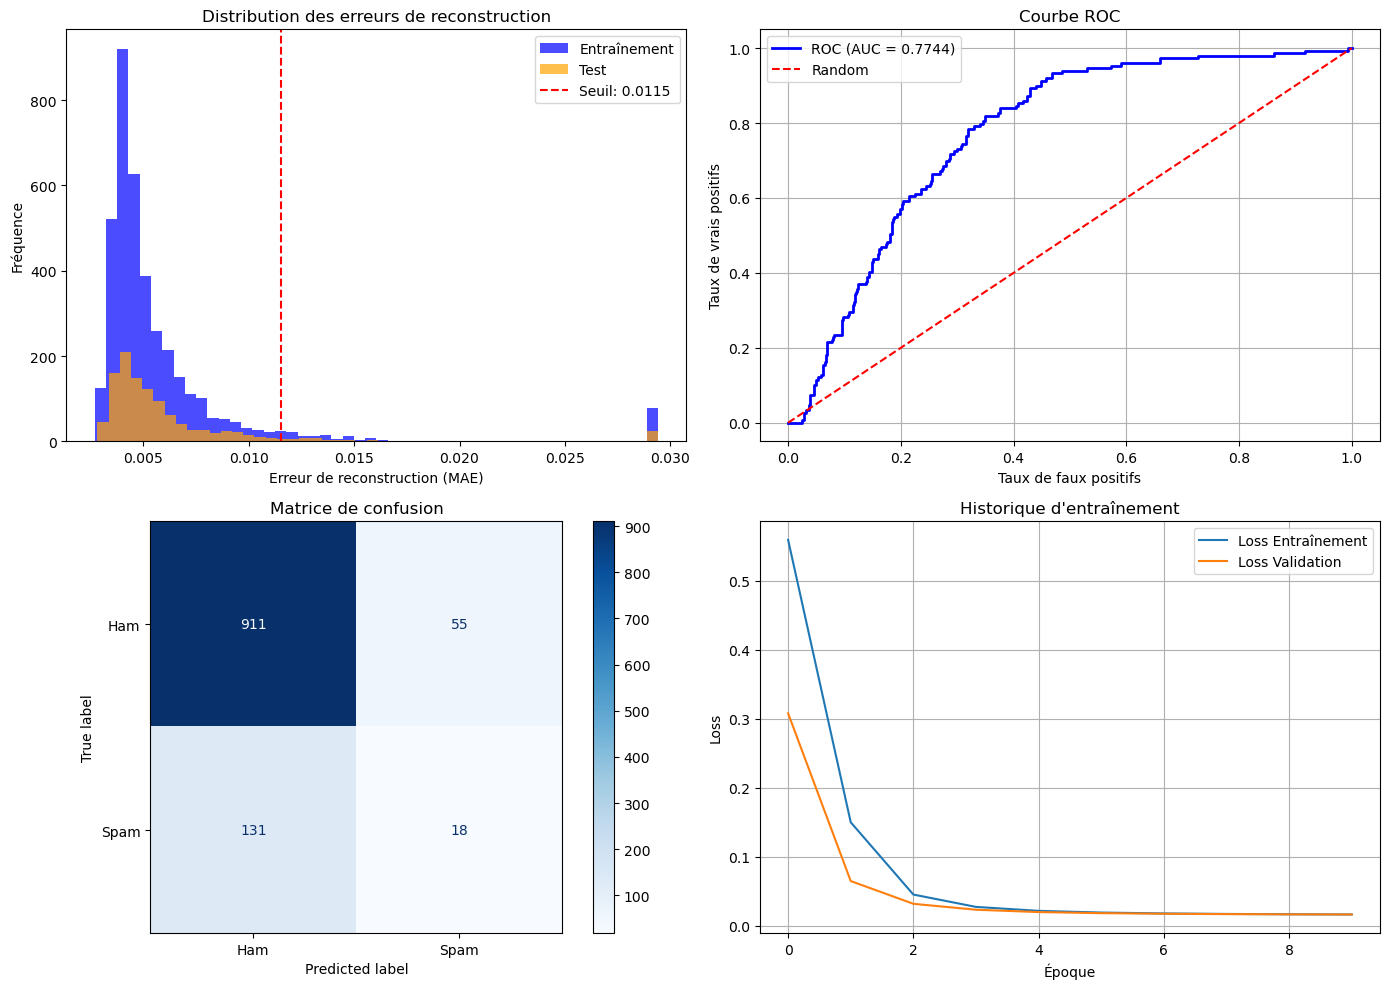

Visualisations complétées!


In [24]:
# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution des erreurs de reconstruction
axes[0, 0].hist(train_mae, bins=50, alpha=0.7, label='Entraînement', color='blue')
axes[0, 0].hist(test_mae, bins=50, alpha=0.7, label='Test', color='orange')
axes[0, 0].axvline(threshold, color='red', linestyle='--', label=f'Seuil: {threshold:.4f}')
axes[0, 0].set_xlabel('Erreur de reconstruction (MAE)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution des erreurs de reconstruction')
axes[0, 0].legend()

# 2. Courbe ROC
fpr, tpr, _ = roc_curve(y_test, test_mae)
axes[0, 1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
axes[0, 1].set_xlabel('Taux de faux positifs')
axes[0, 1].set_ylabel('Taux de vrais positifs')
axes[0, 1].set_title('Courbe ROC')
axes[0, 1].legend()
axes[0, 1].grid()

# 3. Matrice de confusion
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(ax=axes[1, 0], cmap='Blues')
axes[1, 0].set_title('Matrice de confusion')

# 4. Historique d'entraînement
axes[1, 1].plot(history.history['loss'], label='Loss Entraînement')
axes[1, 1].plot(history.history['val_loss'], label='Loss Validation')
axes[1, 1].set_xlabel('Époque')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Historique d\'entraînement')
axes[1, 1].legend()
axes[1, 1].grid()

plt.tight_layout()
plt.show()

print("Visualisations complétées!")

In [49]:
# Fonction pour prédire si un nouveau message est spam ou ham
def predict_message(message):
    # Nettoyage
    cleaned_msg = clean_text(message)
    
    # Vectorisation
    vectorized_msg = vectorizer.transform([cleaned_msg]).toarray()
    
    # Prédiction de l'erreur
    reconstructed = autoencoder.predict(vectorized_msg, verbose=0)
    error = np.mean(np.abs(reconstructed - vectorized_msg))
    
    # Classification
    is_spam = error > threshold
    
    return {
        'message': message,
        'cleaned': cleaned_msg,
        'error': error,
        'threshold': threshold,
        'prediction': 'SPAM⛔ ' if is_spam else 'HAM✅ ',
        'confidence': f"{(error / threshold * 100):.1f}%" if is_spam else f"{(100 - error / threshold * 100):.1f}%"
    }

# Tests avec quelques messages
test_messages = [
    "You have won a prize! Click here to claim your reward.",
    "Hi, how are you doing today?",
    "CLICK NOW!!! Get FREE money!!!",
    "See you tomorrow at 3 PM"
]

print("\n" + "=" * 70)
print("PRÉDICTIONS SUR DE NOUVEAUX MESSAGES")
print("=" * 70)

for msg in test_messages:
    result = predict_message(msg)
    print(f"\nMessage: {result['message']}")
    print(f"Nettoyé: {result['cleaned']}")
    print(f"Erreur de reconstruction: {result['error']:.4f}")
    print(f"Prédiction: {result['prediction']} (Confiance: {result['confidence']})")


PRÉDICTIONS SUR DE NOUVEAUX MESSAGES

Message: You have won a prize! Click here to claim your reward.
Nettoyé: prize click claim reward
Erreur de reconstruction: 0.0290
Prédiction: SPAM⛔  (Confiance: 251.5%)

Message: Hi, how are you doing today?
Nettoyé: hi today
Erreur de reconstruction: 0.0047
Prédiction: HAM✅  (Confiance: 59.3%)

Message: CLICK NOW!!! Get FREE money!!!
Nettoyé: click get free money
Erreur de reconstruction: 0.0045
Prédiction: HAM✅  (Confiance: 61.1%)

Message: See you tomorrow at 3 PM
Nettoyé: see tomorrow 3 pm
Erreur de reconstruction: 0.0054
Prédiction: HAM✅  (Confiance: 53.4%)
